In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift

In [50]:
%matplotlib widget
# makes plots interactive

In [76]:
%matplotlib inline

In [4]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

In [5]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [6]:
dx = 7.5 
dy = 7.5
dt = 1

In [7]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [8]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww, kk, th

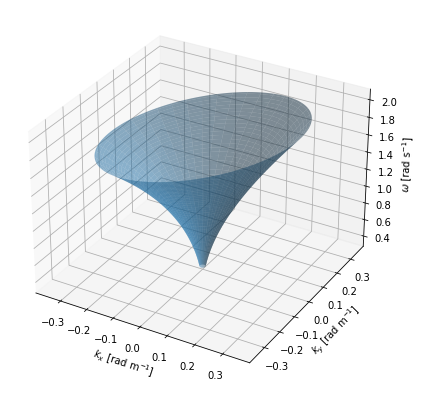

In [9]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww, kk, th = plot_disp_shell(axes, h=1000, z = z, U = U, psi = 0)

In [10]:
dk = 0.005
k1 = np.arange(0.01, 0.35, dk)

In [11]:
k1

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
       0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
       0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
       0.325, 0.33 , 0.335, 0.34 , 0.345])

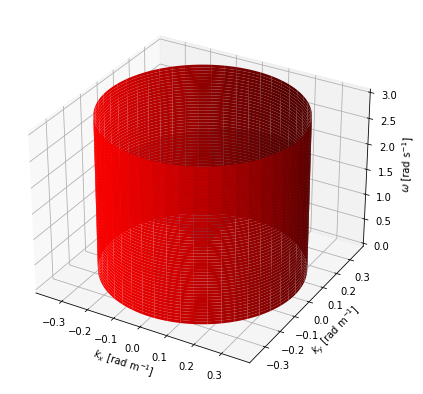

In [12]:
# Define the cylinder parameters
cut_k = 0.35
height = 3

# slice at k = 0.08

# Create data for the cylinder
theta = np.linspace(0, 2 * np.pi, 1000)
z_cylinder = np.linspace(0, height, 1000)
theta, z_cylinder = np.meshgrid(theta, z_cylinder)
x_cylinder = cut_k* np.cos(theta)
y_cylinder = cut_k* np.sin(theta)

# plot surface
fig = plt.figure(figsize=(7, 7))
axes = fig.add_subplot(111, projection='3d')
kx, ky, ww, kk, th = plot_disp_shell(axes, h=1000, z=z, U=U, psi=0)

# Plot cylinder
axes.plot_surface(x_cylinder, y_cylinder, z_cylinder, color='red', alpha=1)

plt.show()

In [13]:
def plot_disp_surf_at_angle(spec_theta, h, z, U, psi):

# (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww, kk, th = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]

    plt.plot(disp_r, disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation at $\Theta$")
    #plt.legend()
    
    return kx, ky, disp_r,disp_ww_for_theta

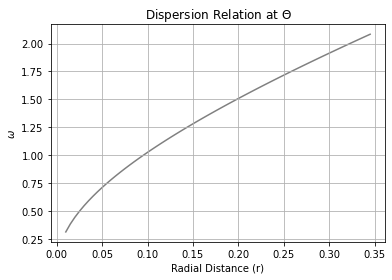

In [14]:
kx, ky, disp_r, disp_ww_for_theta = plot_disp_surf_at_angle(0, h = 1000, z=z, U=U, psi = 0)

In [15]:
y_interpolated = np.interp( cut_k, disp_r, disp_ww_for_theta)
y_interpolated

2.0832176344129563

In [16]:
angles_list = np.linspace(- np.pi,  np.pi, 100)

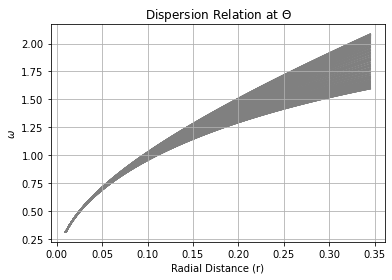

In [17]:
intersection_w_values = []

for i in range(len(angles_list)):
    kx, ky, disp_r, disp_ww_for_theta = plot_disp_surf_at_angle(angles_list[i], h = 1000, z=z, U=U, psi = 0)
    
    w_interpolate = np.interp( cut_k, disp_r, disp_ww_for_theta)
    
    intersection_w_values.append(w_interpolate)

Text(0.5, 1.0, 'Intersection surface')

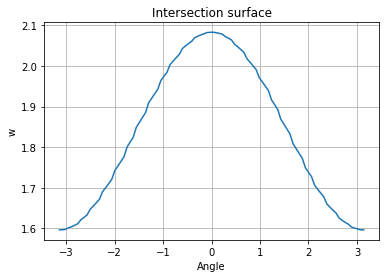

In [18]:
plt.plot(angles_list, intersection_w_values)
plt.grid(True)
plt.xlabel("Angle")
plt.ylabel("w")

plt.title("Intersection surface")

# Find the Spectrum depending on theta / w

In [638]:
cut_k = 0.15

In [639]:
eta = f.get('eta')
eta = np.array(eta)

In [640]:
eta_flipped = np.transpose( np.flip(eta, axis= 2) , (1, 2, 0))
eta_flipped.shape

(67, 67, 1200)

In [641]:
eta = eta_flipped
eta.shape

(67, 67, 1200)

In [642]:
# new version with eta changed dimension 
def cylinder_cross_section(Spectrum, dtheta, power_Spectrum_cut , order=None):
    if order is None:
        order = 4

    Kx_2D = np.squeeze(Kx_3D[:,:,0])
    Ky_2D = np.squeeze(Ky_3D[:,:,0])
    W_1D = np.squeeze(W_3D[0,0,:])

    theta_2D = np.arctan2(-Ky_2D, -Kx_2D)
    theta_3D = np.tile(theta_2D[:, :, np.newaxis], (1, 1, W_1D.size))

    theta_vals = np.arange(-np.pi, np.pi, dtheta)
    S_cyl = np.zeros((W_1D.size, theta_vals.size))

    for ii in range(theta_vals.size):
        theta_diff = np.angle(np.exp(1j * theta_3D) * np.exp(-1j * theta_vals[ii]))
        theta_filt = np.exp(-2 * (theta_diff / dtheta) ** order)
        S_filt = power_Spectrum_cut * theta_filt
        S_cyl[:, ii] = np.nansum(S_filt, axis=(0, 1))

    thetaM, omegaM = np.meshgrid(theta_vals, W_1D)

    Scyl = {
        'P_k': S_cyl,
        'thetaM': thetaM,
        'omegaM': omegaM,
        'Kx_2D': Kx_2D, 
        'Ky_2D': Ky_2D,
        'W_1D': W_1D,
        'theta_2D':theta_2D,
        'theta_3D':theta_3D,
        'theta_vals':theta_vals,
        'theta_diff':theta_diff,
        'theta_filt':theta_filt
    }

    return Scyl

In [643]:
dtheta = 2*dk / cut_k

In [644]:
dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
dk

0.012503851357571316

In [645]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

In [646]:
Kx = spec3d.kx
Ky = spec3d.ky
w = spec3d.w

# ?? difference is here 

In [647]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [648]:
dKx

0.012693303650867849

In [649]:
Norm = dKx * dKy * dW

In [650]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

# power_Spectrum = spec3d.spectrum()

In [651]:
ind_x = Kx <= cut_k+dk
ind_y = Ky <= cut_k+dk
ind_w = (w >= frequencyLimits[0]) & (w <= frequencyLimits[1])
    
Kx_3D, Ky_3D, W_3D = np.meshgrid( Kx[ind_x], Ky[ind_y], w[ind_w], indexing='ij')
    
# Use np.ix_ for boolean indexing to extract the desired values
power_Spectrum_cut = power_Spectrum[np.ix_(ind_x, ind_y, ind_w)]

K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
power_Spectrum_cut[(K_3D < cut_k-dk) | (K_3D > cut_k+dk)] = np.nan
    
power_Spectrum_cut /= np.nansum(power_Spectrum_cut)

In [652]:
np.nanmax(power_Spectrum_cut)

0.017870577567974784

In [653]:
Scyl = cylinder_cross_section( Spectrum , dtheta , power_Spectrum_cut, 4 );

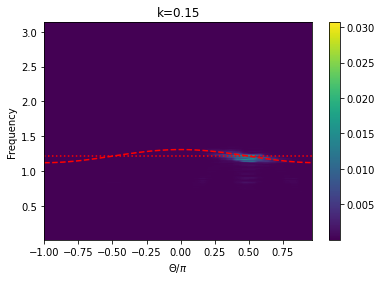

In [654]:
thetaVals = Scyl['thetaM'][0, :] / np.pi 
omegaM_values = Scyl['omegaM'][:, 0]

# Plots Contour Map
plt.imshow( Scyl['P_k'] , extent=[min(thetaVals) , max(thetaVals)  , min(omegaM_values), max(omegaM_values)],
        aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
    
# Plots dotted lines
plt.plot(thetaVals , np.sqrt(1) * np.sqrt(9.81 * cut_k) + 0 * thetaVals, linestyle=':', color='r', linewidth=1.5)
plt.plot(thetaVals , np.sqrt(1) * np.sqrt(9.81 * cut_k) + cut_k * (np.cos(thetaVals*np.pi) * (0.63) + np.sin(thetaVals*np.pi) * 0),
        linestyle='--', color='r', linewidth=1.5)

plt.title(f'k={cut_k}')
plt.xlabel('$\Theta/\pi$')
plt.ylabel('Frequency')

plt.show()

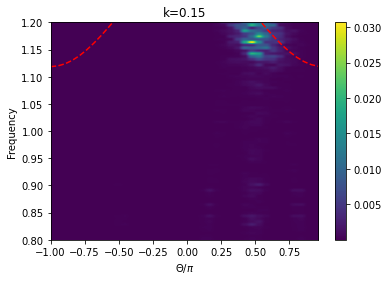

In [655]:
thetaVals = Scyl['thetaM'][0, :] / np.pi 
omegaM_values = Scyl['omegaM'][:, 0]

# Plots Contour Map
plt.imshow( Scyl['P_k'] , extent=[min(thetaVals) , max(thetaVals)  , min(omegaM_values), max(omegaM_values)],
        aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
    
# Plots dotted lines
#plt.plot(thetaVals , np.sqrt(1) * np.sqrt(9.81 * cut_k) + 0 * thetaVals, linestyle=':', color='r', linewidth=1.5)
# straight line above

# curved line 
plt.plot(thetaVals , np.sqrt(1) * np.sqrt(9.81 * cut_k) + cut_k * (np.cos(thetaVals*np.pi) * (0.63) + np.sin(thetaVals*np.pi) * 0),
        linestyle='--', color='r', linewidth=1.5)

plt.title(f'k={cut_k}')
plt.xlabel('$\Theta/\pi$')
plt.ylabel('Frequency')

plt.ylim(0.8,1.2)

plt.show()

Text(0, 0.5, 'Frequency')

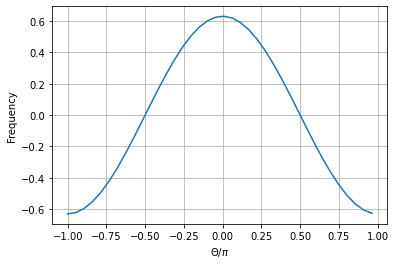

In [656]:
plt.plot(thetaVals ,  (np.cos(thetaVals * np.pi)) * 0.63)

plt.grid(True)
plt.xlabel('$\Theta/\pi$')
plt.ylabel('Frequency')

In [664]:
# Find the threshold value
threshold_value = 0.4 * np.max(Scyl['P_k'])

# Find indices where Scyl['P_k'] is larger than the threshold value
indices = np.where(Scyl['P_k'] > threshold_value)

# Extract corresponding values of thetaVals and omegaM_values
selected_thetaVals = thetaVals[indices[1]]
selected_omegaM_values = omegaM_values[indices[0]]

In [665]:
# Use mirror of the points 
# for when psi =/= 0 then you need to change this mirroring 
# might need to go back and redo filtering 

thetaVals_mirrored = np.concatenate((selected_thetaVals, -selected_thetaVals))
omegaM_mirrored = np.concatenate((selected_omegaM_values, selected_omegaM_values))

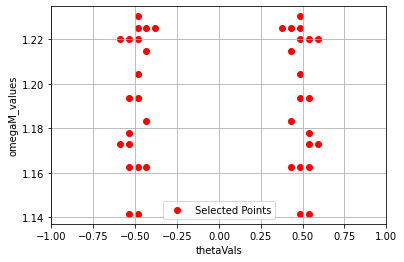

In [666]:
plt.scatter(thetaVals_mirrored, omegaM_mirrored, color='red', label='Selected Points')
plt.xlabel('thetaVals')
plt.ylabel('omegaM_values')
plt.legend()
plt.grid(True)
plt.xlim(-1,1)
plt.show()

In [667]:
def sinusoidinal(x, a, b, c):
    return a*np.cos(b*x)+c

In [668]:
max(omegaM_mirrored)

1.2304571226560022

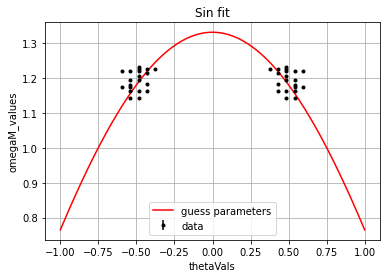

In [681]:
# plot the raw data
plt.errorbar(thetaVals_mirrored, omegaM_mirrored, yerr=0, fmt=".", color = 'black', label = 'data')
plt.grid(True)
plt.xlabel('thetaVals')
plt.ylabel('omegaM_values')


# initial guess
pars0 = ( max(omegaM_mirrored), 1, 0.1)

# overlay exponential 

x = np.linspace(-1, 1, 1000)

plt.plot(x, sinusoidinal(x,*pars0), color = 'red', label = 'guess parameters')

plt.legend();
plt.title("Sin fit");

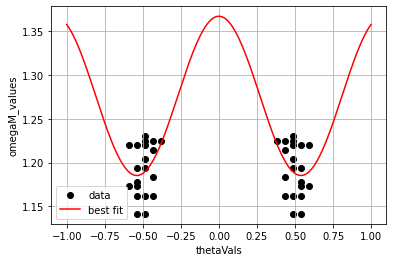

In [682]:
popt, pcov = curve_fit(sinusoidinal, thetaVals_mirrored, omegaM_mirrored, absolute_sigma=True, p0=pars0)

# extract best-fit parameter and its error
a_opt = popt[0]
a_opt_err = np.sqrt(pcov[0, 0])

# plot data
plt.scatter(thetaVals_mirrored, omegaM_mirrored, color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(-1, 1, 1000)
y_fit = sinusoidinal(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")

plt.grid(True)
plt.xlabel('thetaVals')
plt.ylabel('omegaM_values')
#plt.ylim(1.65, 2.08)
plt.legend();

In [683]:
w0 = max(y_fit)  
w0 

1.3672368539462136

In [684]:
wU = ( w0 - np.sqrt(9.81*cut_k) ) / cut_k 

In [685]:
wU

1.027885711979133

# Try actual Algorithm using triplets

In [47]:
def plot_triplets_vs_disp_surface(thresh_freq, max_freq, step_size, h, z, U, psi):
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[600//2:]-f))
        spec = spec3d.spectrum()
        spec_values = spec[600//2 + i,:,:]
        # Gives the spectrum values represented by colour
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
    
    fig = plt.figure(figsize=(7,7))
    axes = fig.add_subplot(111, projection='3d')
    plotting_interface.plot_disp_shell(axes, h, z, U, psi)

    for j in range(0, len(freqs)):
        axes.scatter(kx_list[j], ky_list[j], freqs[j], color='red', s=40)
    
    plt.show()
    
    return kx_list, ky_list, freqs

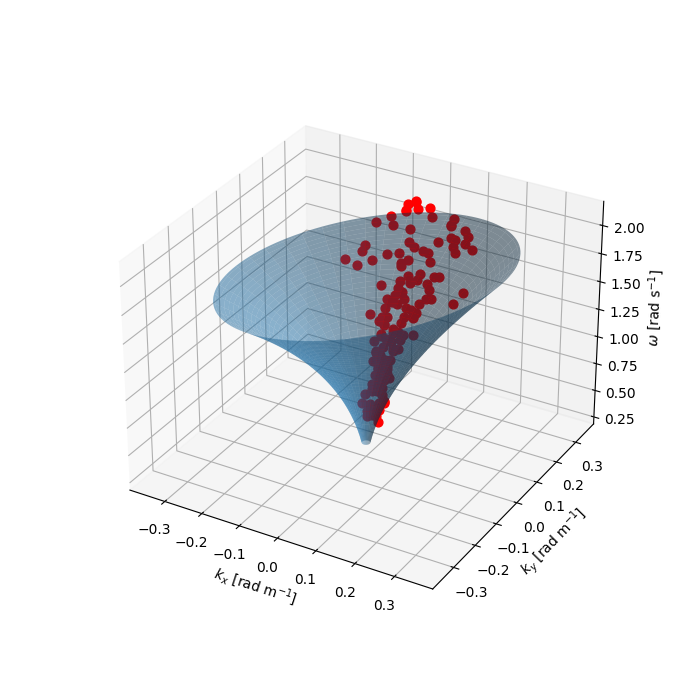

In [53]:
kx_list, ky_list, freqs = plot_triplets_vs_disp_surface(thresh_freq = 0.5 , max_freq = 1.9, step_size = 0.01, h = 1000, z = z, U = U, psi = 0)

In [60]:
kx = np.array(kx_list)
ky = np.array(ky_list)

In [61]:
k_polar = np.sqrt( (kx)**2 + (ky)**2 )
theta = np.arctan2(ky,kx)

In [66]:
 ( freqs - np.sqrt(9.81 * k_polar) )/k_polar

array([-9.74959113e-01, -6.22636654e-01,  8.25565246e-01,  8.20082636e-02,
        1.61338221e+00,  7.86653182e-01, -1.68191667e+00, -1.08190279e+00,
       -8.19297132e-01, -9.34527867e-01, -6.85398267e-01,  4.60587758e-01,
       -1.87139068e-01,  6.19905324e-02, -6.56611520e-01, -4.38110407e-01,
       -2.19609293e-01, -1.10817973e-03, -6.97982396e-01, -5.06908715e-01,
       -1.13279007e-01, -1.24761353e-01,  2.80629477e-01,  4.77583719e-01,
        4.48459689e-01,  6.39533370e-01, -4.57787970e-01, -3.00224577e-01,
       -1.42661183e-01, -1.05511765e-01,  1.72465604e-01,  2.03495473e-01,
        1.63553046e-02, -5.22036020e-01, -3.19926933e-01, -2.63003396e-01,
       -1.33487085e-01, -3.97077279e-03,  1.25545539e-01,  3.36587207e-01,
        3.84578163e-01,  2.81073264e-01, -1.53303895e-01, -9.30183204e-02,
        1.83958237e-02,  1.29809968e-01,  8.52943347e-02,  1.93509318e-01,
        3.01724301e-01, -1.16864480e-01, -1.91478113e-02,  7.85688573e-02,
        6.37639484e-02, -